# Power analysis by bootstrap, inflation factors, and adaptive designs

This notebook will demonstrate how to conduct a power analysis for a one-sample design by using the `bootstrap_predictive_power_1samp` function from the `niseq.power.bootstrap` module. Then, it will show how inflation factors can be used to design a sequential test with the same power as a given fixed-sample test.

In this example, we'll just work with univariate data (so the notebook runs quickly), but usage should be similar for multivariate data. See [the API documentation](https://niseq.readthedocs.io/en/latest/index.html#module-niseq.power.bootstrap) for usage details, as well as details on the Bayesian bootstrap procedure and relevant citations.

## A priori power analysis for a fixed sample design


In [1]:
from niseq.spending_functions import PocockSpendingFunction
from niseq.max_test import sequential_permutation_t_test_1samp
from niseq.power.bootstrap import bootstrap_predictive_power_1samp
from matplotlib import pyplot as plt
from scipy.stats import norm
import numpy as np

To run a power analysis by bootstrap, you'll need some existing data (e.g. from an internal pilot study or a previous study) from which to draw bootstrap resamples. We'll simulate 50 observations for this purpose.

In [2]:
np.random.seed(0)
x = norm.rvs(loc = .7, size = 50) # data to resample from

Now, if we want to estimate the statistical power of a specific (sequential or fixed sample) design, we can use `bootstrap_predictive_power_1samp`. To specify a fixed-sample design, just set `look_times = [n_max]`.

In [3]:
n_fixed = 30
alpha = .05

res = bootstrap_predictive_power_1samp(
    x, 
    test_func = sequential_permutation_t_test_1samp, # or any 1samp test in niseq!
    look_times = [n_fixed], n_max = n_fixed, 
    alpha = alpha,
    seed = 1, n_jobs = -1
)
power_fixed = res['cumulative_power'][0]
print('Fixed sample power is ' + str(power_fixed))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    9.2s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   18.8s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   30.6s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   45.2s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:  1.4min


Fixed sample power is 0.962890625


[Parallel(n_jobs=-1)]: Done 1024 out of 1024 | elapsed:  1.6min finished


## Inflation factors

In general, for a sequential design to acheive the same statistical power as a fixed sample design, the sequential design's maximum sample size needs to be larger. How much larger? That can be predicted with an _inflation factor_, which depends only on the sequential design's characteristics (i.e. number/timing of looks, alpha spending function used) and the desired Type II error. Technically, inflation factors are only guaranteed to be valid for parametric approaches to alpha spending (which depend on some normality assumptions that our permutation-based approach doesn't require). But empirically, it seems that inflation factors for parametric alpha spending translate well to permutation alpha spending, despite the lack of associated theoretical guarantees.

`niseq` doesn't have any built-in functionality to compute inflation factors, but you can use another package to get them. The R packages `rpact` and `gsDesign` are good options. 

In [4]:
def get_inflation_factor(beta, n_looks = 3, spending_type = 'asP'):
    '''
    Computes inflation factor for a sequential design with evenly spaced looks.
    
    Arguments
    ---------
    beta : float
        The Type II error of the fixed sample design 
        that's power you're trying to match.
    n_looks : int
        The number of (evenly spaced) looks at the data.
    spending_type : 'asP' | 'asOF', default: 'asP'
        'asP' uses a Pocock spending function (default)
        'asOF' uses an OBrien Fleming spending function
        
    Returns
    --------
    inflation : float
        The factor by which one must multiply the sample size of a fixed
        sample design with Type II error ``beta`` to yield the maximum sample
        size required for a sequential test of the specified design to 
        acheive the same Type II error. 
        
    Notes
    -------
    Requires R to be installed in your environment. 
    
    '''
    from rpy2 import robjects
    fv = robjects.r(
        '''
        if (!('rpact' %%in%% installed.packages())) {
            install.packages('rpact', type = 'source', repos = 'http://cran.us.r-project.org')
        }
        design <- rpact::getDesignGroupSequential(kMax = %d, beta = %f, typeOfDesign = '%s')
        chars <- rpact::getDesignCharacteristics(design)
        chars$inflationFactor
        '''%(n_looks, beta, spending_type)
    )
    return fv[0]

inflation = get_inflation_factor(1 - power_fixed)
print('inflation factor: %f'%inflation)

inflation factor: 1.138948


In [5]:
# use inflation factor to predict max n needed to match fixed n's power
n_max = int(np.floor(n_fixed * inflation) + 1) # round up
n_max

35

**Note:** Pocock spending functions usually entail higher inflation factors than many other spending functions; O'Brien Fleming, in contrast, tends to result in modest inflation factors. Moreover, the more interim looks you do, the higher the inflation factor. 

Now, let's run a power analysis for the specified sequential design to see if the power matches as expected. 

## A priori power analysis for a sequential design

In [6]:
look_times = [n_max//3, 2*n_max//3, n_max]

results = bootstrap_predictive_power_1samp(
    x, sequential_permutation_t_test_1samp, 
    look_times, n_max, 
    alpha = alpha,
    seed = 1, n_jobs = -1,
    spending_func = PocockSpendingFunction(alpha, n_max)
)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    8.4s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   20.4s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   36.5s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   57.9s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 1024 out of 1024 | elapsed:  2.2min finished


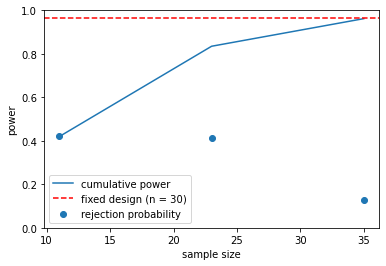

Expected sample size: 19.94
Sample size savings: 33.53 percent


In [7]:
plt.plot(look_times, results['cumulative_power'], label = 'cumulative power')
plt.axhline(power_fixed, color = 'red', label = 'fixed design (n = %d)'%n_fixed, linestyle = '--')
plt.scatter(look_times, results['rejection_probability'], label = 'rejection probability')
plt.ylabel('power')
plt.xlabel('sample size')
plt.ylim((0, 1))
plt.legend()
plt.show()

n_exp = results['n_expected']
print('Expected sample size: %.2f'%n_exp)
print('Sample size savings: %.2f percent'%(100*(n_fixed - n_exp)/n_fixed))

Note that, even though the _maximum_ sample size for the sequential design is larger than the fixed-sample design with the same power (i.e. inflation factor is greater than one), the _expected_ sample size is actually a good bit smaller. This is where the efficiency advantage of sequential designs shine; the probability of rejecting the null hypothesis at an interim analysis is substantial. (And this efficiency gain is usually larger for high-powered designs.)

In [8]:
results

{'uncorr_instantaneous_power': [0.58984375, 0.91015625, 0.9794921875],
 'rejection_probability': [0.419921875, 0.4150390625, 0.126953125],
 'cumulative_power': [0.419921875, 0.8349609375, 0.9619140625],
 'uncorr_cumulative_power': [0.58984375, 0.9140625, 0.982421875],
 'n_expected': 19.94140625,
 'n_simulations': 1024,
 'n_orig_data': 50,
 'conditional': False,
 'test_func': 'sequential_permutation_t_test_1samp',
 'test_func_kwargs': {'spending_func': 'PocockSpendingFunction',
  'look_times': [11, 23, 35],
  'n_max': 35,
  'alpha': 0.05}}

## Conditional power analysis and adaptive designs

Since it generally [requires a much larger sample size to obtain a decent effect size estimate than to reject the null hypothesis](http://datacolada.org/20), one could argue it is often folly to run an internal pilot study to estimate effect size before ever running a study testing for the existence of an effect. Indeed, the pilot sample sizes required to obtain a stable power estimate, given the considerable uncertainty surrounding the true effect size in small sample studies, are estimated to be [higher than the sample sizes commonly seen in confirmatory neuroimaging studies](https://doi.org/10.1177/1745691614528520). (`bootstrap_predictive_power_1samp` does incorporate uncertainty about the effect size estimate into its power estimates, since it uses a [Bayesian bootstrap procedure](http://www.sumsar.net/blog/2015/04/the-non-parametric-bootstrap-as-a-bayesian-model/), somewhat mitigating this problem, but I wouldn't take that to the bank in all cases.) Thus, it would be desirable to include the sample used for your power analysis in your confirmatory study to avoid wasting resources.

This possibility is afforded by sequential designs. From [Lakens (2014)](https://doi.org/10.1002/ejsp.2023):

> During an interim analysis, the observed results can be used toadapt the study design, for example, by increasing the totalsample size that will be collected. According to the European Medicines Agency (2006), “a study design is ‘adaptive’ if statistical methodology allows the modification of a design element (e.g., sample-size, randomization ratio, number of treatment arms) at an interim analysis with full control of Type I error rate. ”With interim analyses, it becomes possible to use data collected early in a study as an internal pilot study (Wittes & Brittain, 1990) and use the effect size estimate from an interim analysis to determine the sample size for the full study.


You could, for example:
1. Choose a preliminary $n_\max$ and $n_1$ at which to run your first sequential hypothesis test.
2. After collection $n_1$ samples, run your hypothesis test as in any sequential design. If the null is rejected, you're done!
3. If you didn't reject the null in (2), estimate _conditional power_: the probability of the study design ($n_\max$ and other planned look times) rejecting the null if run to completion, given the data already observed. 
4. If the conditional power estimated in (3) is unacceptably low, you can adjust $n_\max$ and planned look times until power is acceptable. This would be an example of an _adaptive design._
5. If the $n_\max$ determined in (4) is impractical to collect, you may choose to stop data collection for futitlity. 

Let's run an example conditional power analysis. `bootstrap_predictive_power_1samp` can run such an analysis if you set `conditional = True`.

In [9]:
np.random.seed(0)

n_max = 100
x = norm.rvs(loc = .2, size = n_max//2) # data for first look
look_times = [n_max//2, n_max]

sf = PocockSpendingFunction(alpha, n_max)
results = bootstrap_predictive_power_1samp(
    x, sequential_permutation_t_test_1samp, 
    look_times, n_max, 
    alpha = alpha,
    conditional = True,
    n_jobs = -1,
    spending_func = sf
)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    7.2s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   17.2s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   30.2s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   49.8s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 1024 out of 1024 | elapsed:  2.0min finished


In [10]:
conditional_power = results['cumulative_power'][-1]
conditional_power

0.8505859375

Let's say we find that power too low for our comfort. We can change $n_\max$, but we have to adjust our alpha spending function accordingly. We can do this using the `PiecewiseSpendingFunction` class.

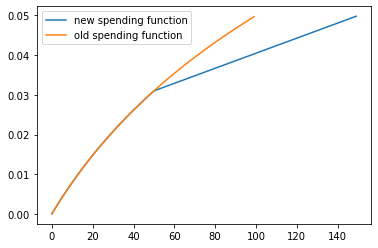

In [11]:
from niseq.spending_functions import PiecewiseSpendingFunction

new_sf = PiecewiseSpendingFunction(sf, break_n = look_times[0], new_max_n = 150)
plt.plot(
    [n for n in range(new_sf.max_n)], [new_sf(n) for n in range(new_sf.max_n)],
    label = 'new spending function'
)
plt.plot(
    [n for n in range(sf.max_n)], [sf(n) for n in range(sf.max_n)],
    label = 'old spending function'
)
plt.legend()
plt.show()

**Note that, up until the point at which we decided to update our design, our new and old spending functions are the same.** This is critical for maintaining appropriate control of the false positive rate, since we must maintain an accurate record of the Type I error spent up to this point.

Now, we can run a power analysis for our updated design. To use the updated spending function in your new design, you just set the `spending_func` argument to your new spending function (here `new_sf`) when you call your statistical test (here `sequential_permutation_t_test_1samp`) or your power analysis function (`bootstrap_predictive_power_1samp`).

In [12]:
new_results = bootstrap_predictive_power_1samp(
    x, sequential_permutation_t_test_1samp, 
    look_times = [look_times[0], new_sf.max_n], 
    n_max = new_sf.max_n, 
    alpha = alpha,
    conditional = True,
    seed = 0,
    n_jobs = -1,
    spending_func = new_sf
)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    7.4s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   18.7s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   33.8s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   53.9s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 1024 out of 1024 | elapsed:  2.1min finished


**Note that we include the look we already did in our updated `look_times` parameter.** This, too, is critical for computing proper adjusted significance thresholds. 

In [13]:
new_conditional_power = new_results['cumulative_power'][-1]
new_conditional_power

0.9169921875

You can continue adjusting $n_\max$ and your planned looks until the resulting conditional power is satisfactory. Additionally, you're free to run a conditional power analysis after every look if you'd like, and if it is the case that you find an impractically large $n_\max$ is required to reject the null hypothesis with sufficiently high probability, then you may consider stopping the study for futility. These options provide considerable flexibility. Again, from [Lakens (2014)](https://doi.org/10.1002/ejsp.2023):

> Researchers should decide whether they want to use an adaptive design, or whether they want to plan for a large sample size, and rely on interim analyses to stop the data collection when a convincing level of significance has been observed (for a discussion, see Tsiatis & Mehta, 2003). A useful recommendation is to use sequential analyses based on a reasonable effect size estimate, but include the possibility of an adaptive design if the effect size is lower, but still of interest to the researcher. Instead of conditional power, researchers can also use predictive power, a Bayesian alternative to conditional power (Spiegelhalter, Freedman, & Blackburn, 1986).

(Note, again, that `bootstrap_predictive_power_1samp` does technically use Bayesian predictive power.)

The latter case highlighted here is particularly notable if you've based your intial $n_\max$ on a previous study, since effect sizes reported in the literature tend to be inflated by virtue of the ["winner's curse"](https://doi.org/10.1097/ede.0b013e31818131e7). 